# **Data Generation**

In [9]:
import numpy as np
import pandas as pd
import torch 
import torch.nn as nn


n = 50
d = 3

x = np.random.uniform(-1, 1, (n, d))
print("input data shape:")
print(x.shape)

#y1 = x1^2 + 2*x2 + x3
#y2 = x1^3 + 2*x2^2 + 5*x3
def f(x):
  y1 =  (x[:,0]*x[:,0]) + (2*x[:,1]) + x[:,2]
  y2 = (x[:,0]*x[:,0]*x[:,0]) + (2*x[:,1]*x[:,1]) + (5*x[:,2])
  return np.vstack((y1,y2)).T

y_true = f(x)

print("Output data shape:")
print(y_true.shape)

input data shape:
(50, 3)
Output data shape:
(50, 2)


# **3 layer NN using pytorch - uses SGD optimizer from pytorch lib and custom gradient descent logic**

In [10]:
def Display3D(ax, x, output):
  from sklearn.manifold import TSNE
  df_true = pd.concat([pd.DataFrame(x),pd.DataFrame(output)], axis=1)
  perplexity = 50
  tsne_3d = TSNE(n_components=3, perplexity=perplexity)
  TCs_3d = pd.DataFrame(tsne_3d.fit_transform(df_true))
  TCs_3d.columns = ["TC1_3d","TC2_3d","TC3_3d"]
  ax.scatter3D(TCs_3d['TC1_3d'], TCs_3d['TC2_3d'], TCs_3d['TC3_3d'])

def DisplayPlotAndLoss(x, y_true, y_pred):
  
  import matplotlib.pyplot as plt
  from mpl_toolkits.mplot3d import Axes3D

  fig = plt.figure()
  ax = fig.add_subplot(111, projection='3d')
  Display3D(ax, x, y_true)
  Display3D(ax, x, y_pred)
  plt.tight_layout()
  plt.show()

In [11]:
class MSE:
  def __call__(self, y_pred, y_true):
    self.y_pred = y_pred
    self.y_true = y_true
    return ((y_true-y_pred) ** 2).mean()

  def backward(self):
    n = self.y_true.shape[0]
    self.gradient = 2. * (self.y_pred - self.y_true) / n
    return self.gradient

In [12]:
class LinearCustom:
  def __init__(self, input_dim, output_dim):
    self.linear = nn.Linear(input_dim, output_dim)

  def __call__(self, x):
    self.x = x
    return self.linear(x)

  def Module(self):
    return self.linear
    

  def backward(self, gradient):
    self.weights_gradient = self.x.T @ gradient
    self.bias_gradient = gradient.sum()
    self.x_gradient = gradient @ self.linear.weight
    return self.x_gradient

  def update(self, lr):
    self.linear.weight =  nn.Parameter(self.linear.weight - lr*self.weights_gradient.T)
    self.linear.bias =  nn.Parameter(self.linear.bias - lr*self.bias_gradient.T)


In [13]:
class ReluCustom:
  def __init__(self):
    self.relu = nn.ReLU()

  def Module(self):
    return self.relu

  def __call__(self, x):
    self.input = x
    self.output = self.relu(x)
    return self.output
    

  def backward(self, gradient):
    self.input_gradient = (self.input > 0) * gradient
    return self.input_gradient


In [14]:
class TorchModel(nn.Module):

  def __init__(self, input_dim, num_hidden=1):
    super().__init__()
    self.linear1 = LinearCustom(input_dim, num_hidden)
    self.relu1 = ReluCustom()
    self.linear2 = LinearCustom(num_hidden, num_hidden)
    self.relu2 = ReluCustom()
    self.linear3 = LinearCustom(num_hidden, 2)
    self.add_module("l1", self.linear1.Module())
    self.add_module("r1", self.relu1.Module())
    self.add_module("l2", self.linear2.Module())
    self.add_module("r2", self.relu2.Module())
    self.add_module("l3", self.linear3.Module())

  def forward(self, x):
    l1 = self.linear1(x)
    r1 = self.relu1(l1)
    l2 = self.linear2(r1)
    r2 = self.relu2(l2)
    return self.linear3(r2)

  def backward(self, gradient):
    self.l3_gradient = self.linear3.backward(gradient)
    self.r2_gradient = self.relu2.backward(self.l3_gradient)
    self.l2_gradient = self.linear2.backward(self.r2_gradient)
    self.r1_gradient = self.relu1.backward(self.l2_gradient)
    self.l1_gradient = self.linear1.backward(self.r1_gradient)

  def update(self, lr):
    self.linear1.update(lr)
    self.linear2.update(lr)
    self.linear3.update(lr)

  def fit(self, x, y_true, epoch, lr):
    
    for i in range(epoch):
      loss = MSE()
      y = self.forward(x)
      cost = loss(y, y_true)
      if i%500 == 0:
        print(f"Epoch: {i+1} ===> loss: {cost}")
      loss_gradient = loss.backward()
      self.backward(loss_gradient)
      self.update(lr)
    return y

  def fit_with_SGD(self, x, y_true, epoch, loss, lr):
    optimizer = torch.optim.SGD(self.parameters(), lr)
    for i in range(epoch):
      optimizer.zero_grad()
      y = self.forward(x)
      loss_val = loss(y, y_true)
      if i%200 == 0:
        print(f"Epoch: {i+1} ===> loss: {loss_val}")
      loss_val.backward()
      optimizer.step()



  

In [15]:
model_traing_with_SGD = TorchModel(3)
model_custom_gradient_descent = TorchModel(3)
x_tensor = torch.tensor(x).float()
y_true_tensor = torch.tensor(y_true).float()
loss = nn.MSELoss()
y_pred_SGD = model_traing_with_SGD.fit_with_SGD(x_tensor, y_true_tensor, 2000, loss, 0.1)
y_pred_custom = model_custom_gradient_descent.fit(x_tensor, y_true_tensor, 2000, 0.1)

Epoch: 1 ===> loss: 7.18782901763916
Epoch: 201 ===> loss: 6.5046491622924805
Epoch: 401 ===> loss: 6.5046491622924805
Epoch: 601 ===> loss: 6.5046491622924805
Epoch: 801 ===> loss: 6.5046491622924805
Epoch: 1001 ===> loss: 6.5046491622924805
Epoch: 1201 ===> loss: 6.5046491622924805
Epoch: 1401 ===> loss: 6.5046491622924805
Epoch: 1601 ===> loss: 6.5046491622924805
Epoch: 1801 ===> loss: 6.5046491622924805
Epoch: 1 ===> loss: 6.6500396728515625
Epoch: 501 ===> loss: 6.5046491622924805
Epoch: 1001 ===> loss: 6.5046491622924805
Epoch: 1501 ===> loss: 6.5046491622924805


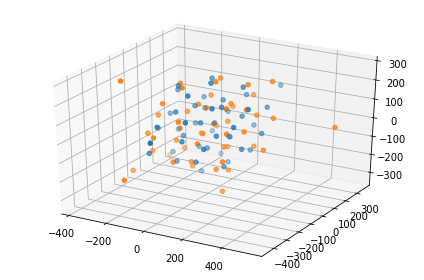

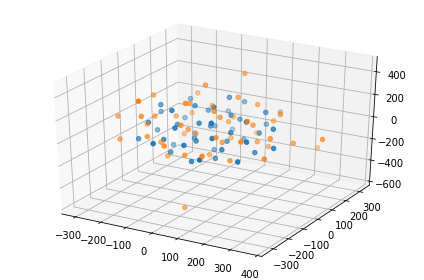

In [16]:
DisplayPlotAndLoss(x, y_true, y_pred_SGD)
DisplayPlotAndLoss(x, y_true, y_pred_custom)